In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error

plt.style.use('Solarize_Light2')

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

# Time-Series Data Forecasting

Time-series data forecasting involves predicting future values based on historical observations. Accurate forecasts are crucial for various fields, including finance, economics, and weather prediction. In this notebook, we'll explore essential concepts and methods for effective time-series forecasting.

## Introduction

Forecasting accurate values for time-series data requires addressing underlying patterns and variations. One fundamental principle is to ensure that the data is stationary. A stationary time series has constant mean, variance, and autocorrelation properties over time. Non-stationary data with trends or seasonal variations can lead to inaccurate forecasts.

In this notebook, we'll cover the following topics:

1. **Data Stationarization**: We'll explore techniques to transform and stationarize data, making it suitable for analysis. Methods like de-trending, differencing, and logging help remove trends and seasonality.

2. **Benchmark Forecasting Methods**: We'll delve into basic forecasting methods that serve as benchmarks. These include average forecasting, naive methods, and the drift method, which provide simple baselines for comparison.

3. **Historical Data Adjustments**: Sometimes, data might contain variations due to calendar effects. We'll discuss adjustments to remove such variations and ensure more accurate forecasts.

4. **Box-Cox Transformations**: To stabilize variance in non-stationary data, we can use Box-Cox transformations. These transformations are particularly useful when dealing with exponential trends.

5. **Residuals and Evaluation**: Understanding residuals is essential to assess how well a forecasting model captures data patterns. We'll explore methods to evaluate residuals and assess their quality.

6. **Prediction Interval**: Prediction intervals provide a range within which future values are likely to fall. We'll examine how to calculate prediction intervals for forecasts.

7. **Exponential Smoothing**: This technique assigns varying weights to past observations to forecast future values. We'll explore simple exponential smoothing and its application.

Whether you're new to time-series forecasting or looking to enhance your existing knowledge, this notebook will provide valuable insights and practical methods to improve your forecasting accuracy.


### Data Stationarization

#### De-trending

De-trending removes underlying trends in the series. Different methods are used based on the nature of the data:
- Indexed Data: Divide the series by a price index to remove currency-related trends.
- Non-indexed Data: Estimate trend type (constant, linear, exponential) and apply appropriate method.
- Differencing: Subtract periodical values to remove seasonal or cyclical patterns.
- Logging: Linearize exponential trends using logarithms.

#### Rolling Statistics

Plotting rolling means and variances helps visually inspect series. Trend and varying variance indicate non-stationarity.

## Forecasting Methods

### Benchmark Methods

#### Average Forecasting

$$\hat{y}_{T+h | T} = \sum_{i=1}^T (y_i)/T$$

#### Naive Method

$$\hat{y}_{T+h | T} = y_T$$

#### Seasonal Naive Method

$$\hat{y}_{T+h | T} = y_{T+h - m(k+1)},$$
where $m$ is the seasonal period and $k$ is based on $(h - 1)/m$

#### Drift Method

$$\hat{y}_{T+h | T} = y_T + \frac{h}{T-1}\sum_{t=2}^T (y_t - y_{t-1})$$

### Historical Data Adjustments

- Calendar Adjustments: Use average daily production to remove month length variation.

### Box-Cox Transformations

Box-Cox transforms help stabilize variance:
$$w_t = \begin{cases}
\log(y_t), & \text{if } \lambda = 0 \\
(y_t^{\lambda} - 1) / \lambda, & \text{otherwise}
\end{cases}$$

Bias-adjustment:
$$y_t = \begin{cases}
\exp(w_t)[1+\frac{\sigma_h^2}{2}], & \text{if } \lambda = 0 \\
(\lambda w_t + 1)^{1/\lambda}\big[1 + \frac{\sigma_h^2(1-\lambda)}{2(\lambda w_t + 1)^2}\big], & \text{otherwise}
\end{cases}$$

### Residuals and Evaluation

Residuals ($e_t = y_t - \hat{y}_t$) help check if a model captured data information. Good residuals exhibit:
- No correlation
- Zero mean
- Constant variance
- Normal distribution

#### Portmanteau Tests for Autocorrelation

- Box-Pierce Test: $Q = T \sum_{k=1}^l r_k^2$
- Ljung-Box Test: $Q^* = T(T+2) \sum_{k=1}^l (T-k)^{-1} r_k^2$

### Forecast Error Metrics

- MAE: Mean Absolute Error
- RMSE: Root Mean Squared Error
- Percentage Error: $p_t = 100e_t/y_t$
- MAPE: Mean Absolute Percentage Error
- sMAPE: Symmetric Mean Absolute Percentage Error

### Prediction Interval

Prediction interval: $$\hat{y}_{T+h | T} \pm c \hat{\sigma}_h$$

### Forecasting Standard Deviation

Methods for standard deviation forecasting:
- Mean
- Naive
- Seasonal Naive
- Drift Forecast

### Bootstrapped Residuals

Using bootstrapped residuals for prediction:
$$y_{T+i} = \hat{y}_{T+i|T+i-1} + e_{T+i}$$

### Exponential Smoothing

Exponential smoothing assigns more weight to recent observations. Simple exponential smoothing:
$$\hat{y}_{T+1|T} = \sum_{j=0}^{T-1} \alpha (1-\alpha)^j y_{T-j} + (1 - \alpha)^T l_0$$


In [2]:
def simple_exponential_smoothing(series, alpha):
    """
    Apply simple exponential smoothing to the input time series.
    
    Parameters:
    series (numpy.ndarray): The input time series.
    alpha (float): Smoothing parameter (0 <= alpha <= 1).
    
    Returns:
    numpy.ndarray: Smoothed time series.
    """
    results = np.zeros_like(series)
    results[0] = series[0]
    
    for t in range(1, series.shape[0]):
        results[t] = alpha * series[t] + (1 - alpha) * results[t-1]
        
    return results

def plot_exponential_smoothing(series, alphas):
    """
    Plot exponential smoothing with different alpha values.
    
    Parameters:
    series (numpy.ndarray): The input time series.
    alphas (list): List of alpha values to try.
    """
    plt.figure(figsize=(15, 7))
    
    for alpha in alphas:
        smoothed = simple_exponential_smoothing(series, alpha)
        plt.plot(smoothed, label='Alpha {:.2f}'.format(alpha))
    
    plt.plot(series, label='Actual')
    plt.legend(loc='best')
    plt.axis('tight')
    plt.title('Exponential Smoothing')
    plt.grid(True)
    plt.show()

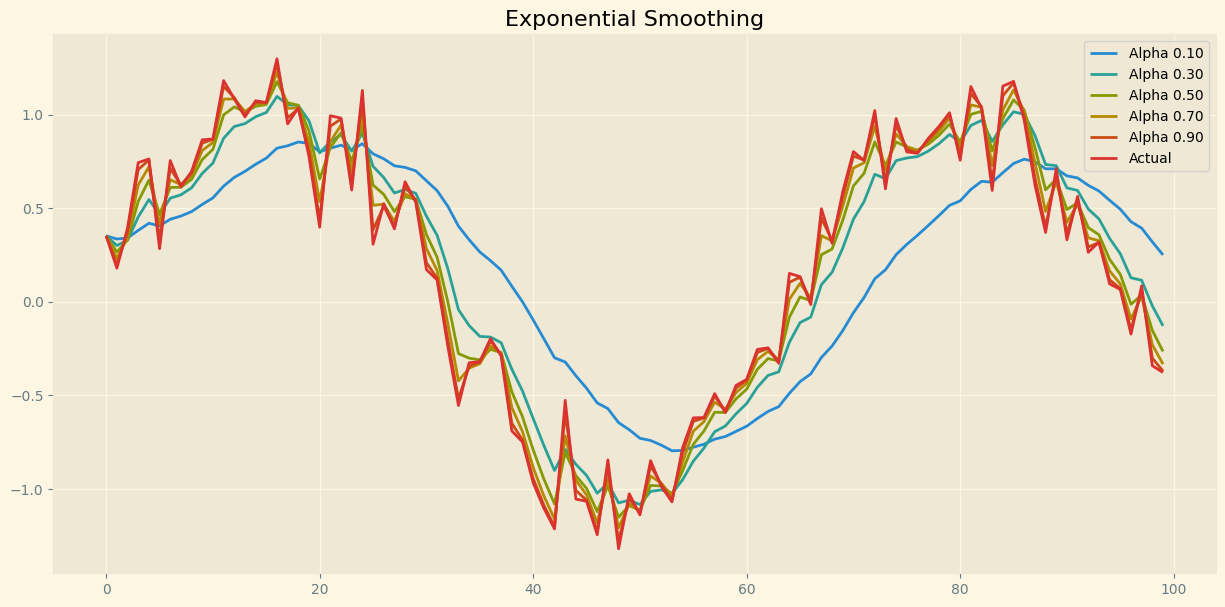

In [3]:
# Generate example data
np.random.seed(0)
n = 100
time = np.arange(n)
actual_values = np.sin(0.1 * time) + np.random.normal(0, 0.2, n)

# Plot exponential smoothing with different alpha values
alphas_to_try = [0.1, 0.3, 0.5, 0.7, 0.9]
plot_exponential_smoothing(actual_values, alphas_to_try)

### Holt's Linear Trend Method

Holt's linear trend method is used when a time series exhibits a trend component. Incorporating the trend information helps in producing better forecasts by considering both the current level and the trend direction.

- **Forecast Equation**: The forecast for future time points is a combination of the current level and the trend.
$$\hat{y}_{t+h|t} = l_t + h b_t$$

- **Level Equation**: The current level is updated based on the observed value and the previous level and trend.
$$l_t = \alpha y_t + (1 - \alpha)(l_{t-1} + b_{t-1})$$

- **Trend Equation**: The trend is estimated considering the difference between the current and previous levels, along with the previous trend.
$$b_t = \beta^*(l_t - l_{t-1}) + (1-\beta^*)b_{t-1}$$
Here, $0 \leq \beta^* \leq 1$ is the smoothing parameter for the trend.

The level ($l_t$) represents the predicted point, while the trend ($b_t$) represents the slope of the time series. The choice of $\alpha$ and $\beta^*$ impacts the performance of the method. Larger values of $\beta^*$ give less weight to past trends when estimating the current trend.

To initiate the trend, the first observed trend can be used. For example, the initial trend can be computed as $(y_2 - y_1)/1$, where $y_1$ and $y_2$ are the first two observed values.

#### Damped Trend Methods

In some cases, it's advantageous to dampen the trend in the forecast to avoid over-forecasting for longer horizons. The dumped trend methods introduce a damping parameter $\phi$.

- **Forecast Equation**: The forecast is a combination of the current level and the damped trend, where the trend is damped using a geometric series.
$$\hat{y}_{t+h|t} = l_t + (\phi + \phi^2 + ... + \phi^h) b_t$$

- **Level Equation**: Similar to the basic Holt's method, the level is updated based on the observed value, the previous level, and the previous trend.
$$l_t = \alpha (y_t - s_{t-m}) + (1 - \alpha)(l_{t-1} + b_{t-1})$$

- **Trend Equation**: The trend equation remains similar to the basic method.
$$b_t = \beta^*(l_t - l_{t-1}) + (1-\beta^*) b_{t-1}$$
Here, $0 \leq \phi \leq 1$ is a damping parameter, usually chosen such that $0.8 \leq \phi < 1$.

The dumped trend methods provide an option to control the influence of the trend in the forecast, which can be beneficial when dealing with long-range forecasts.

In [4]:
def Holts_linear_trend_method(series, alpha, beta, n_preds=2):
    """
    Given a series, alpha, beta and n_preds (number of
    forecast/prediction steps), perform the prediction.
    """
    n_record = series.shape[0]
    results = np.zeros(n_record + n_preds)
    
    level = series[0]
    results[0] = series[0]
    trend = series[1] - series[0]
    
    for t in range(1, n_record + 1):
        if t >= n_record:
            value = results[t-1]
        else:
            value = series[t]
            
        previous_level = level
        level = alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - previous_level) + (1 - beta) * trend
        results[t] = level + trend
    
    if n_preds > 1:
        results[n_record + 1:] = level + np.arange(2, n_preds + 1) * trend
    return results

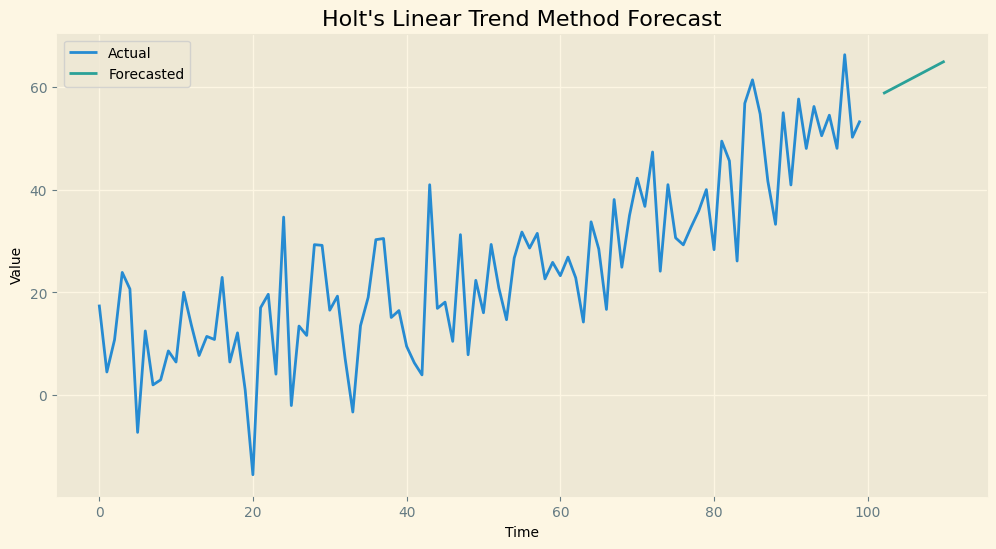

In [7]:
np.random.seed(0)
n = 100
time = np.arange(n)
actual_values = 0.5 * time + np.random.normal(0, 10, n)

alpha = 0.2
beta = 0.1
n_preds = 10

# Forecast using Holt's linear trend method
forecasted_values = Holts_linear_trend_method(actual_values, alpha, beta, n_preds)

# Plot actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(time, actual_values, label='Actual')
plt.plot(np.arange(n + 2, n + n_preds + 1), forecasted_values[n + 1:], label='Forecasted')
plt.legend()
plt.title("Holt's Linear Trend Method Forecast")
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

### Holt-Winters Seasonal Methods

Holt-Winters seasonal methods are particularly useful for time series with seasonality. These methods consider both the level, trend, and seasonal components to produce forecasts. There are two variations: additive and multiplicative. Additionally, there's a damped variation that introduces a damping parameter.

#### Additive Seasonal Variation

- **Forecast Equation**: The forecast includes the current level, trend, and seasonal component.
$$\hat{y}_{t+h|t} = l_t + h b_t + s_{t + h - m (k+1)}$$

- **Level Equation**: The level is updated using the observed value and previous level and trend.
$$l_t = \alpha y_t + (1 - \alpha)(l_{t-1} +  b_{t-1})$$

- **Trend Equation**: Similar to previous methods, the trend is calculated using the difference between the current and previous levels, along with the previous trend.
$$b_t = \beta^*(l_t - l_{t-1}) + (1-\beta^*) b_{t-1}$$

- **Seasonal Equation**: The seasonal component is calculated based on the observed value, previous level, and previous seasonal component.
$$s_t = \gamma(y_t - l_{t-1} - b_{t-1}) + (1 - \gamma)s_{t-m}$$

Here, $k = \text{INT}((h-1)/m)$ is a dumping parameter, often chosen such that $0.8 \leq \gamma < 1$.

#### Multiplicative Seasonal Variation

- **Forecast Equation**: The forecast involves the level, trend, and seasonal component, but the seasonal component is multiplied.
$$\hat{y}_{t+h|t} = (l_t + h b_t)s_{t + h - m (k+1)}$$

- **Level Equation**: The level equation considers the observed value, previous level, and previous seasonal component.
$$l_t = \alpha y_t/s_{t-m} + (1 - \alpha)(l_{t-1} + b_{t-1})$$

- **Trend Equation**: The trend equation remains the same as in the additive variation.
$$b_t = \beta^*(l_t - l_{t-1}) + (1-\beta^*) b_{t-1}$$

- **Seasonal Equation**: The seasonal component is computed using a combination of the observed value, previous level, previous trend, and previous seasonal component.
$$s_t = \gamma y_t/ (l_{t-1} + b_{t-1}) + (1 - \gamma)s_{t-m}$$

#### Holt-Winters Seasonal Damped Method

- **Forecast Equation**: The forecast combines the damped level, damped trend, and seasonal component.
$$\hat{y}_{t+h|t} = [l_t + (\phi + \phi^2 + ... + \phi^h) b_t] s_{t + h - m (k+1)}$$

- **Level Equation**: The damped level considers the observed value, previous level, and a damped previous trend.
$$l_t = \alpha y_t/s_{t-m} + (1 - \alpha)(l_{t-1} + \phi b_{t-1})$$

- **Trend Equation**: The damped trend equation involves the damped previous trend and previous level.
$$b_t = \beta^*(l_t - l_{t-1}) + (1-\beta^*) \phi b_{t-1}$$

- **Seasonal Equation**: The seasonal component is computed using a combination of the observed value, damped previous level, damped previous trend, and previous seasonal component.
$$s_t = \gamma y_t/ (l_{t-1} + \phi b_{t-1}) + (1 - \gamma)s_{t-m}$$

The Holt-Winters seasonal methods provide powerful tools for forecasting time series with varying seasonality, allowing for flexibility and accuracy in predictions.

In [11]:
class HoltWinters:
    """Scikit-learn like interface for Holt-Winters method."""

    def __init__(self, season_len=24, alpha=0.5, beta=0.5, gamma=0.5):
        self.beta = beta
        self.alpha = alpha
        self.gamma = gamma
        self.season_len = season_len

    def fit(self, series):
        beta = self.beta
        alpha = self.alpha
        gamma = self.gamma
        season_len = self.season_len
        seasonals = self._initial_seasonal(series)

        predictions = []
        smooth = series[0]
        trend = self._initial_trend(series)
        predictions.append(smooth)

        for i in range(1, len(series)):
            value = series[i]
            previous_smooth = smooth
            seasonal = seasonals[i % season_len]
            smooth = alpha * (value - seasonal) + (1 - alpha) * (previous_smooth + trend)
            trend = beta * (smooth - previous_smooth) + (1 - beta) * trend
            seasonals[i % season_len] = gamma * (value - smooth) + (1 - gamma) * seasonal
            predictions.append(smooth + trend + seasonals[i % season_len])

        self.trend_ = trend
        self.smooth_ = smooth
        self.seasonals_ = seasonals
        self.predictions_ = predictions
        return self
    
    def _initial_trend(self, series):
        season_len = self.season_len
        total = 0.0
        for i in range(season_len):
            total += (series[i + season_len] - series[i]) / season_len

        trend = total / season_len
        return trend

    def _initial_seasonal(self, series):
        season_len = self.season_len
        n_seasons = len(series) // season_len

        season_averages = np.zeros(n_seasons)
        for j in range(n_seasons):
            start_index = season_len * j
            end_index = start_index + season_len
            season_average = np.sum(series[start_index:end_index]) / season_len
            season_averages[j] = season_average

        seasonals = np.zeros(season_len)
        seasons = np.arange(n_seasons)
        index = seasons * season_len
        for i in range(season_len):
            seasonal = np.sum(series[index + i] - season_averages) / n_seasons
            seasonals[i] = seasonal

        return seasonals

    def predict(self, n_preds=10):
        predictions = self.predictions_
        original_series_len = len(predictions)
        for i in range(original_series_len, original_series_len + n_preds):
            m = i - original_series_len + 1
            prediction = self.smooth_ + m * self.trend_ + self.seasonals_[i % self.season_len]
            predictions.append(prediction)

        return predictions

def timeseries_cv_score(params, series, loss_function, season_len=24, n_splits=3):
    errors = []    
    alpha, beta, gamma = params
    time_series_split = TimeSeriesSplit(n_splits=n_splits) 

    for train, test in time_series_split.split(series):
        model = HoltWinters(season_len, alpha, beta, gamma)
        model.fit(series[train])

        predictions = model.predict(n_preds=len(test))
        test_predictions = predictions[-len(test):]
        test_actual = series[test]
        error = loss_function(test_actual, test_predictions)
        errors.append(error)

    return np.mean(errors)

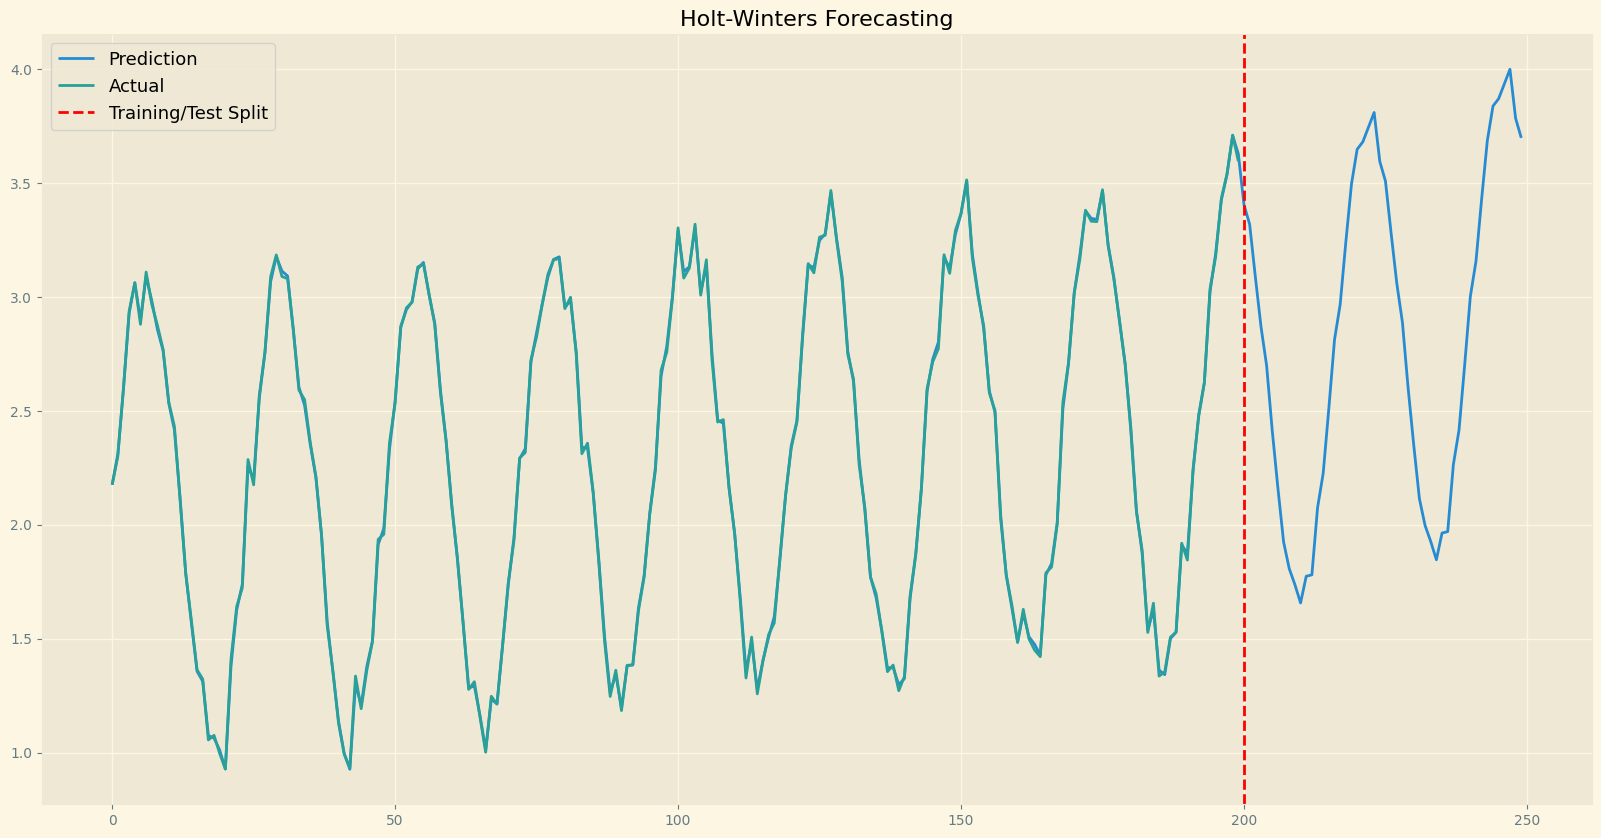

In [12]:
np.random.seed(0)
n_points = 200
season_len = 24
x = np.arange(n_points)
seasonal_component = np.sin(2 * np.pi * x / season_len)
trend_component = 0.5 * x / n_points
noise = np.random.normal(0, 0.1, n_points)
data = 2 + seasonal_component + trend_component + noise

# Parameter tuning
x0 = [0.5, 0.5, 0.5]
opt = minimize(timeseries_cv_score, x0=x0, 
               args=(data, mean_squared_log_error), 
               method='TNC', bounds=((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
model = HoltWinters(season_len, alpha_final, beta_final, gamma_final)
model.fit(data)
predictions = model.predict(n_preds=50)

# Visualization
plt.figure(figsize=(20, 10))
plt.plot(predictions, label='Prediction')
plt.plot(data, label='Actual')
plt.axvline(len(data), color='r', linestyle='--', label='Training/Test Split')
plt.title('Holt-Winters Forecasting')
plt.grid(True)
plt.legend(loc='best', fontsize=13)
plt.show()

Final Model Selection Algorithm in ARIMA Class:
• The first step is to plot the time series and observe it. Even from visual analysis, you can make certain conclusions: whether there is seasonality in the data, what is the seasonal period, are there any gaps or outliers in the series, do you need to stabilize the variance, should you exclude the beginning of the series because the initial values are quite different from the values at the end.

• The next step, if necessary, is to stabilize the variance. Stabilization can be done using the Box-Cox method or by taking the logarithm, which is a special case of the same method.

• If the investigated series is non-stationary, you need to determine the order of differencing that makes it stationary. Thus, the parameters d and D of the ARIMA model are fixed.

• Next, you need to plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) and use these plots to determine approximate values for the parameters p, q, P, Q. Essentially, these values are initial approximations from which the search for different models begins.

• The obtained models need to be trained, compared using the Akaike information criterion (AIC), and the one that minimizes it should be selected.

• It's necessary to examine the residuals of the resulting model to understand how good it is, whether it can theoretically be improved, and whether there are any visible shortcomings. More about residual analysis will be discussed later.

ADF vs KPSS test:

Case 1: Both tests conclude that the series is not stationary - The series is not stationary.
Case 2: Both tests conclude that the series is stationary - The series is stationary.
Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. The trend needs to be removed to make the series strictly stationary. The detrended series is checked for stationarity.
Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is used to make the series stationary. The differenced series is checked for stationarity.
$\text{AIC} = 2k - 2\log(L)$ - Akaike Information Criterion for model selection, the smaller the value, the better.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [21]:
def if_data_staionary_dfuller(df, clmn_name):
    print(f" > Is the data {clmn_name} stationary ?")
    dftest = adfuller(df[clmn_name].dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, 
                                                                                "not" if v<dftest[0] else "", 
                                                                                100-int(k[:-1])))
    print()

In [22]:
def if_data_stationary_kpss(df, clmn_name):
    from statsmodels.tsa.stattools import kpss
    print("Results of KPSS Test:")
    kpsstest = kpss(df[clmn_name].dropna(), regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [ ]:
df = pd.read_csv('your_data.csv')

# Assume your data column is 'value'
clmn_name = 'value'

# Check if the data is stationary using ADFuller test
if_data_staionary_dfuller(df, clmn_name)

# Check if the data is stationary using KPSS test
if_data_stationary_kpss(df, clmn_name)

# Plot ACF and PACF to determine p and q values
plt.figure(figsize=(12, 6))
plot_acf(df[clmn_name], lags=30)
plt.title('ACF')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df[clmn_name], lags=30)
plt.title('PACF')
plt.show()

# Assuming you've identified the values of p, d, and q based on the plots and tests
p = 1
d = 1
q = 1

# Create and fit ARIMA model
model = ARIMA(df[clmn_name], order=(p, d, q))
results = model.fit()

# Display model summary
print(results.summary())

# Generate predictions
n_preds = 10  # Number of predictions
forecast, stderr, conf_int = results.forecast(steps=n_preds)

# Plot the original data and the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df[clmn_name], label='Original Data')
plt.plot(range(len(df), len(df) + n_preds), forecast, label='Forecast')
plt.fill_between(range(len(df), len(df) + n_preds), forecast - 1.96 * stderr, forecast + 1.96 * stderr, color='gray', alpha=0.2)
plt.title('ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()